<a href="https://colab.research.google.com/github/aolivieri/colon/blob/master/colon_colonoscopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls 

colon_colonoscopy.h5	    colon_histological.h5     Kvasir
colon_colonoscopy.ipynb     colon_histological.ipynb  preprocess_crop.py
colon_colonoscopy_v2.ipynb  colon_image_sets	      README.md


In [2]:
# Importing the libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.regularizers import l2
tf.__version__

'2.3.1'

In [3]:
import tensorflow.keras.backend as K

In [33]:
# K.clear_session()

In [6]:
# Part 1 - Data Preprocessing

# Generating images for the Training set
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)

# Generating images for the Test set
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

# Creating the Training set
training_set = train_datagen.flow_from_directory('./colon_image_sets/training_set', 
                                                 target_size = (224, 224),
                                                 subset='training')

# Creating the Validation set
validation_set = train_datagen.flow_from_directory('./colon_image_sets/training_set',
                                                   target_size = (224, 224),
                                                   subset='validation')

# Creating the Validation set
test_set = test_datagen.flow_from_directory('./colon_image_sets/test_set',
                                                   target_size = (224, 224))

Found 7200 images belonging to 2 classes.
Found 1800 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
a, b = training_set.next()
a.shape, b.shape

((32, 224, 224, 3), (32, 2))

In [8]:
from PIL import Image
import numpy as np

[1. 0.]


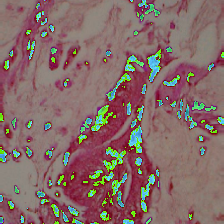

In [10]:
print(b[0])
Image.fromarray(np.uint8(a[0]))

[1. 0.]


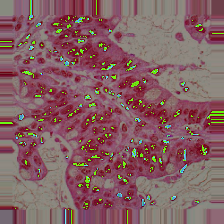

In [11]:
print(b[2])
Image.fromarray(np.uint8(a[2]))

In [14]:
from collections import Counter
counter = Counter(training_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     
print(class_weights)

{0: 1.0, 1: 1.0}


In [20]:
# Transfer Learning

from tensorflow.keras.models import *

pretrained_nn = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# Freeze all layers
for l in pretrained_nn.layers:
  l.trainable = False

global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()(pretrained_nn.output)
fc1 = tf.keras.layers.Dense(512, activation='relu')(global_avg_pool)
fc2 = tf.keras.layers.Dense(512, activation='relu')(fc1)
output = tf.keras.layers.Dense(2, activation='softmax')(fc2)

model = Model(pretrained_nn.input, output)

sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0.001, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [21]:
# Training
from keras import callbacks
hist = model.fit(training_set,
                  steps_per_epoch = training_set.__len__(),
                  epochs = 50,
                  validation_data = test_set,
                  validation_steps = test_set.__len__(),
                  callbacks=[callbacks.ModelCheckpoint('cp-model.h5', save_best_only=True)])

Epoch 1/50
225/225 [==============================] - 86s 384ms/step - loss: 0.0680 - accuracy: 0.9787 - val_loss: 0.0125 - val_accuracy: 0.9950
Epoch 2/50
225/225 [==============================] - 80s 356ms/step - loss: 0.0192 - accuracy: 0.9950 - val_loss: 0.0086 - val_accuracy: 0.9980
Epoch 3/50
225/225 [==============================] - 79s 351ms/step - loss: 0.0137 - accuracy: 0.9965 - val_loss: 0.0058 - val_accuracy: 0.9980
Epoch 4/50
225/225 [==============================] - 78s 348ms/step - loss: 0.0122 - accuracy: 0.9962 - val_loss: 0.0064 - val_accuracy: 0.9980
Epoch 5/50
225/225 [==============================] - 79s 349ms/step - loss: 0.0106 - accuracy: 0.9968 - val_loss: 0.0043 - val_accuracy: 0.9970
Epoch 6/50
225/225 [==============================] - 78s 347ms/step - loss: 0.0092 - accuracy: 0.9975 - val_loss: 0.0043 - val_accuracy: 0.9980
Epoch 7/50
225/225 [==============================] - 78s 348ms/step - loss: 0.0086 - accuracy: 0.9979 - val_loss: 0.0044 - val_ac

In [42]:
#model.save('colon_colonoscopy.h5')

In [23]:
# Avalia o modelo na validação
model.load_weights('cp-model.h5')
score = model.evaluate(validation_set,verbose=1)

print('Valid loss:', score[0])
print('Valid acc:', score[1])

57/57 [==============================] - 19s 335ms/step - loss: 0.0049 - accuracy: 0.9989
Valid loss: 0.0049221208319067955
Valid acc: 0.9988889098167419


In [24]:
# AUC

from sklearn.metrics import roc_auc_score
import numpy as np

def print_auc(model, generator):
  preds = model.predict(generator)
  #preds = np.argmax(preds, axis=1)

  batch_index = 0
  data_list = []
  while batch_index <= generator.batch_index:
    _, label = generator.next()
    data_list.extend(label)
    batch_index = batch_index + 1

  gt = np.argmax(data_list, axis=1)
  auc = roc_auc_score(gt, preds[:,1])
  print("auc :", auc)

In [25]:
print_auc(model, training_set)
print_auc(model, test_set)

ValueError: Found input variables with inconsistent numbers of samples: [7168, 7200]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()